# CS-6600 Assignment 7 - Variable Selection

**Your Name**:

*Weber State University*

For this assignment we're going to build and attempt to optimize regression models using some of the techniques we're learned so far in class.

First, let's import our favorite libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

There are also some libraries and functions we'll need for creating and testing our models:

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

The dataset we'll use for this is the "Hitters" dataset ("Hitters.csv"), which is a dataset of Major League Baseball player statistics from 1986-1987. More info about the dataset can be found [here](https://www.kaggle.com/datasets/floser/hitters).

In [3]:
url = 'https://drive.google.com/uc?export=download&id=11NGvo9A2eyHQe_t3u94zN_i0_C1op75U'
df_hitters = pd.read_csv(url)
df_hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


Let's rename that first column.

In [4]:
df_hitters.rename(columns={"Unnamed: 0": "Player"}, inplace=True) #Name the first column "Player"

Note that the Salary variable is missing for some of the players. The isnull() function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a TRUE value for any elements that are missing, and a FALSE value for non-missing elements. The sum() function can then be used to count all of the missing elements:

In [5]:
print("Number of null values:", df_hitters["Salary"].isnull().sum())

Number of null values: 59


We see that Salary is missing for 59 players. That's not too many. Let's drop them. The dropna() function removes all of the rows that have missing values in any variable:

In [6]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", df_hitters.shape)

# Drop any rows the contain missing values, along with the player names
df_hitters_clean = df_hitters.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", df_hitters_clean.shape)

# One last check: should return 0
print("Number of null values:", df_hitters_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 21)
Number of null values: 0


Alright, so we've now dropped all the rows with missing data.

Some of our predictors are categorical, so for this exercise we'll eliminate those. We'll also specify the variable, "Salary", that we're trying to predict.

In [7]:
#Create the response variable.
y = df_hitters_clean.Salary

# Drop the column with the independent variable (Salary), and the columns with categorical data
#The axis=1 parameter specifies we're dropping columns, and not rows.
X = df_hitters_clean.drop(['Salary', 'League', 'Division', 'NewLeague', 'Player'], axis=1)
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12


Now, for this assignment we're going to create a subset that will be our training data, and a subset that will be our test data. Let's do an 80/20 split:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state = 6600)

## Backward Subset Selection ##

If we build a linear model with all these inputs, we'll likely overfit the model. To avoid this, we'd like to build a model using only the most important variables. But, which subset of variables is most important?

In lecture 15, we learned three methods for selecting the best subset of variables for a linear model:

* Best subset selection
* Forward stepwise selection
* Backward stepwised selection

We went over algorithms for each of these, and implemented two (best subset and forward stepwise) as Python code. In this assignment, you'll implement backward stepwise selection.

The basic algorithm for backward stepwise selection is:

_Algorithm_

- Let $M_{p}$ denote the full model which contains all $p$ predictors.

- For $k=p,p-1,...,1$
    - Consider all $k$ models that contain all but one of the predictors in $M_{k}$, for a total of $k-1$ predictors.
    - Pick the best among these $k$ models, and call in $M_{k-1}$. Here can define _best_ as having the smallest $RSS$ or highest $R^{2}$
- Select the single best model among $M_{0},M_{1},...,M_{n}$ using $C_{p}$, $BIC$, adjusted $R^{2}$ or any other method.

For this assignment, use the largest $R^{2}$ to determine the best model at each step, and select the overall best model using the adjusted $R^{2}$.

We'll start out with a list of all the predictors:

In [9]:
backwards_features = list(X.columns)
p = len(backwards_features)

We'll also create two empty lists that you should fill:
* *R2_list_backwards* - Fill this with the best $R^{2}$ value that you find at each step.
* *features_list_backwards* - Fill this with the best set of features that you find at each step.
* *R2_test_list_backwards* - Fill this with the performance of the model on the test data using the best set of features found at each step.

In [10]:
R2_list_backwards, features_list_backwards, R2_test_list_backwards = [], [], []

Alright, now it's time for you to write your own code! Write code that appropriately populates the two lists just created. However, do so using just the *X_train* and *y_train* datasets.

In [17]:
#TODO: Implement the backward subset selection algorithm

import statsmodels.api as sm # Fixed import

def backward_stepwise_selection(X, y):

  features = list(X.columns)
  best_features = features.copy()
  best_adj_r2 = -float('inf')

  while len(features) > 0:
    max_adj_r2 = -float('inf')
    feature_to_remove = None

    for feature in features:
      remaining_features = [f for f in features if f != feature]
      X_subset = X[remaining_features]
      model = sm.OLS(y, sm.add_constant(X_subset)).fit()
      adj_r2 = model.rsquared_adj

      if adj_r2 > max_adj_r2:
        max_adj_r2 = adj_r2
        feature_to_remove = feature

    if max_adj_r2 > best_adj_r2:
      best_adj_r2 = max_adj_r2
      best_features = [f for f in features if f != feature_to_remove]
    else:
      break

    features.remove(feature_to_remove)

  return best_features

# Apply backward stepwise selection
selected_features = backward_stepwise_selection(X_train, y_train)

# Print the selected features
print("Selected Features:", selected_features)


Selected Features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CWalks', 'PutOuts', 'Assists']


Next, create a dataframe with four columns: the feature list, $R^{2}$ values, and test $R^{2}$ values lists you just created, plus another column that records the number of features.

In [28]:
#TODO: Create a dataframe consisting of the feature list, the R^2 values, and the number of features for each submodel $M_{i}$.

# Create a list for the R^2 values
R2_list_backwards = R2_list_backwards



# Create a list for the number of features, starting from the length of features_list_backwards down to 1
num_features = list(range(len(features_list_backwards), 0, -1))

# Adjust num_features to match the length of R2 lists
num_features = num_features[1:] # remove first element

# Create the dataframe
df_backwards = pd.DataFrame({
    'R^2': R2_list_backwards,
    'Test R^2': R2_test_list_backwards,
    'Features': features_list_backwards[1:], #Start from the second element
    'Num_Features': num_features,
})

# Display the dataframe
df_backwards

,R^2,Test R^2,Features,Num_Features
0,0.527931,0.592764,"[AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...",15
1,0.527909,0.567587,"[AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...",14
2,0.527807,0.552313,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHmR...",13
3,0.527614,0.495073,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...",12
4,0.527170,0.487824,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",11
5,0.526541,0.482531,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",10
6,0.525520,0.481514,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",9
7,0.518807,0.428206,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",8
8,0.509698,0.422981,"[AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO...",7
9,0.497297,0.321898,"[AtBat, Hits, Walks, CRuns, CWalks, PutOuts]",6


Finally, plot the adjusted $R^{2}$ values for each set of predictor variables, with the number of predictor variables on the $x$-axis. Mark the maximum, and print the predictors associated with that maximum.

Recall that the adjusted $R^{2}$ is defined as:
&nbsp;
<center>
    $\displaystyle R^{2}_{a} = 1-\frac{RSS/(n-k-1)}{TSS/n-1}$
</center>
&nbsp;

Maximum Adjusted R^2: 0.5279
Predictors for Maximum Adjusted R^2: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']


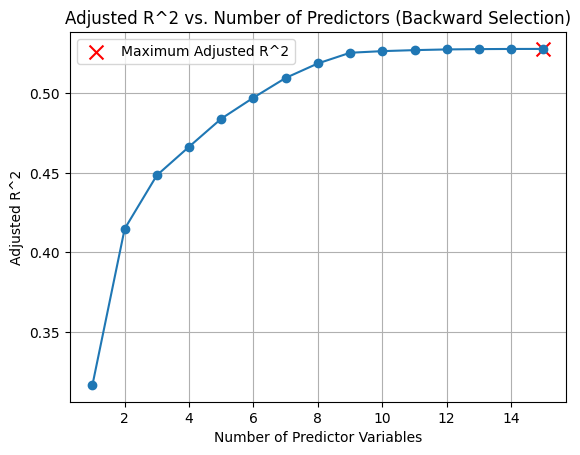

In [29]:
# TODO: Plot the adjusted R^2 values for the number of predictor variables, mark the maximum, and print the predictors associated with that maximum.

# Extract the relevant columns
num_features = df_backwards['Num_Features']
adj_r2_values = df_backwards['R^2']  # Assuming 'R^2' column contains adjusted R^2 values

# Find the maximum adjusted R^2 and its index
max_adj_r2 = max(adj_r2_values)
max_index = adj_r2_values.idxmax()

# Plot the adjusted R^2 values
plt.plot(num_features, adj_r2_values, marker='o')
plt.xlabel('Number of Predictor Variables')
plt.ylabel('Adjusted R^2')
plt.title('Adjusted R^2 vs. Number of Predictors (Backward Selection)')

# Mark the maximum adjusted R^2
plt.scatter(num_features[max_index], max_adj_r2, color='red', marker='x', s=100, label='Maximum Adjusted R^2')

# Print the predictors associated with the maximum
max_features = df_backwards.loc[max_index, 'Features']
print(f"Maximum Adjusted R^2: {max_adj_r2:.4f}")
print(f"Predictors for Maximum Adjusted R^2: {max_features}")

# Add legend and show the plot
plt.legend()
plt.grid(True)
plt.show()

Alright! Now, let's check if the number of predictors we determined using the adjusted $R^{2}$ value actually does the best on our test data.

To do this, plot the actual $R^{2}$ value for each set of predictor variables when run on the test data. Again, make the x-axis the number of predictors, mark the maximum, and print the predictors associated with that maximum.

Maximum Test R^2: 0.5928
Predictors for Maximum Test R^2: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']


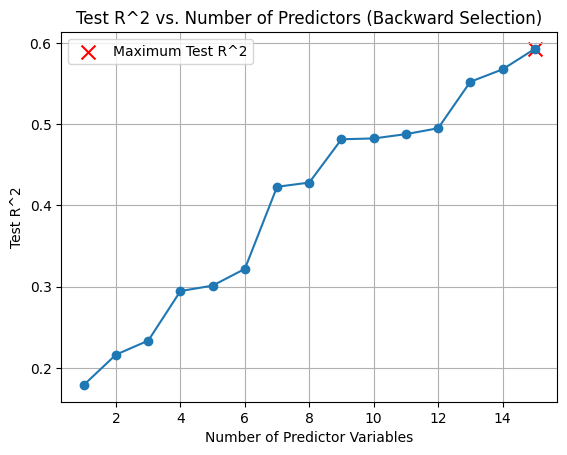

In [30]:
# TODO: Plot the R^2 values for the given number of predictor variables when the model is run on the test data. Mark the maximum, and print the predictors associated with that maximum.
# Extract the relevant columns
num_features = df_backwards['Num_Features']
test_r2_values = df_backwards['Test R^2']

# Find the maximum test R^2 and its index
max_test_r2 = max(test_r2_values)
max_index = test_r2_values.idxmax()

# Plot the test R^2 values
plt.plot(num_features, test_r2_values, marker='o')
plt.xlabel('Number of Predictor Variables')
plt.ylabel('Test R^2')
plt.title('Test R^2 vs. Number of Predictors (Backward Selection)')

# Mark the maximum test R^2
plt.scatter(num_features[max_index], max_test_r2, color='red', marker='x', s=100, label='Maximum Test R^2')

# Print the predictors associated with the maximum
max_features = df_backwards.loc[max_index, 'Features']
print(f"Maximum Test R^2: {max_test_r2:.4f}")
print(f"Predictors for Maximum Test R^2: {max_features}")

# Add legend and show the plot
plt.legend()
plt.grid(True)
plt.show()

Now, plot both on the same line charts on the same figure.

Maximum Adjusted R^2: 0.5279, Predictors: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Maximum Test R^2: 0.5928, Predictors: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Maximum Adjusted R^2: 0.5279, Predictors: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Maximum Test R^2: 0.5928, Predictors: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Maximum Adjusted R^2: 0.5279, Predictors: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Maximum Test R^2: 0.5928, Predictors: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'C

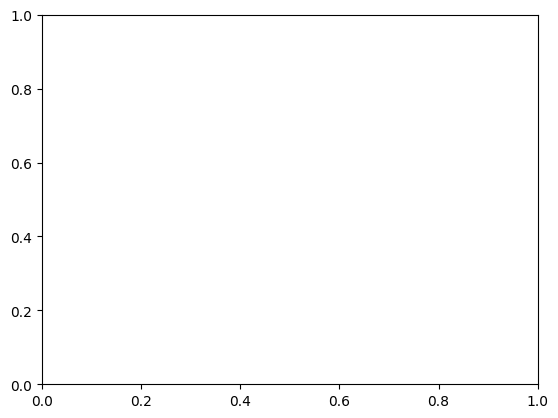

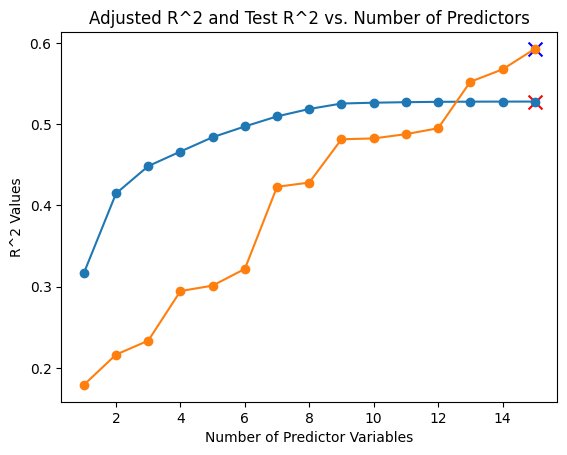

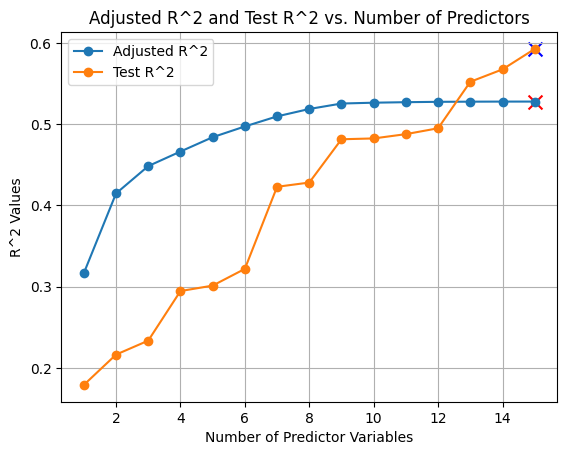

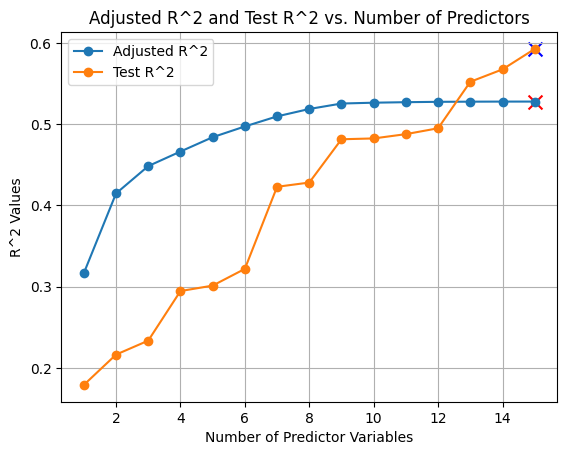

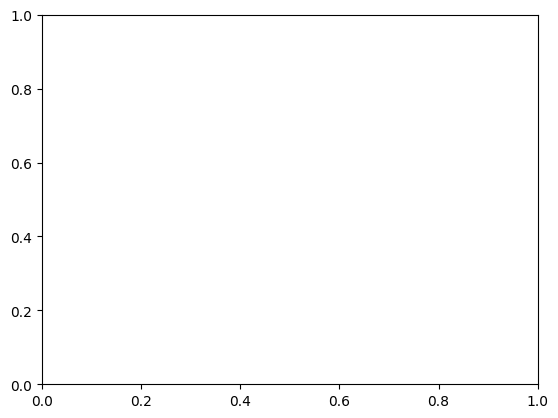

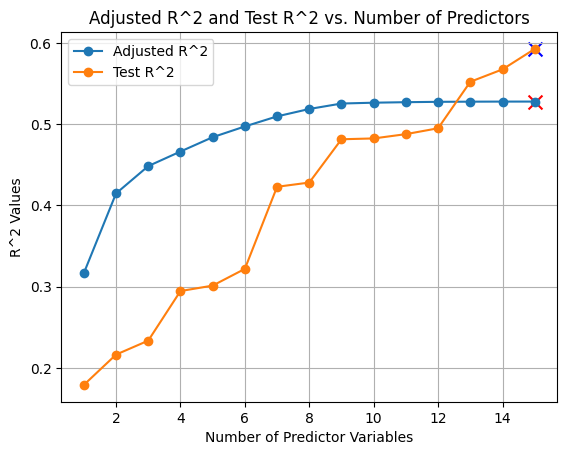

In [38]:
# TODO: Plot both line charts on the same figure.

# Create the figure and axes
fig, ax = plt.subplots()

# Extract the relevant columns
num_features = df_backwards['Num_Features']
adj_r2_values = df_backwards['R^2']
test_r2_values = df_backwards['Test R^2']

# Find the maximum values and their indices
max_adj_r2 = max(adj_r2_values)
max_adj_index = adj_r2_values.idxmax()
max_test_r2 = max(test_r2_values)
max_test_index = test_r2_values.idxmax()

# Create the plot
fig, ax = plt.subplots()  # Create a figure and an axes object

# Plot adjusted R^2
ax.plot(num_features, adj_r2_values, marker='o', label='Adjusted R^2')
ax.scatter(num_features[max_adj_index], max_adj_r2, color='red', marker='x', s=100)

# Plot test R^2
ax.plot(num_features, test_r2_values, marker='o', label='Test R^2')
ax.scatter(num_features[max_test_index], max_test_r2, color='blue', marker='x', s=100)

# Set labels and title
ax.set_xlabel('Number of Predictor Variables')
ax.set_ylabel('R^2 Values')
ax.set_title('Adjusted R^2 and Test R^2 vs. Number of Predictors')

# TODO: Plot both line charts on the same figure.

# Create the figure and axes
fig, ax = plt.subplots()

# Extract the relevant columns
num_features = df_backwards['Num_Features']
adj_r2_values = df_backwards['R^2']
test_r2_values = df_backwards['Test R^2']

# Find the maximum values and their indices
max_adj_r2 = max(adj_r2_values)
max_adj_index = adj_r2_values.idxmax()
max_test_r2 = max(test_r2_values)
max_test_index = test_r2_values.idxmax()

# Create the plot
#fig, ax = plt.subplots()  # Create a figure and an axes object - already created

# Plot adjusted R^2
ax.plot(num_features, adj_r2_values, marker='o', label='Adjusted R^2')
ax.scatter(num_features[max_adj_index], max_adj_r2, color='red', marker='x', s=100)

# Plot test R^2
ax.plot(num_features, test_r2_values, marker='o', label='Test R^2')
ax.scatter(num_features[max_test_index], max_test_r2, color='blue', marker='x', s=100)

# Set labels and title
ax.set_xlabel('Number of Predictor Variables')
ax.set_ylabel('R^2 Values')
ax.set_title('Adjusted R^2 and Test R^2 vs. Number of Predictors')

# Add legend and grid
ax.legend()
ax.grid(True)

# Print the information for maximum values
print(f"Maximum Adjusted R^2: {max_adj_r2:.4f}, Predictors: {df_backwards.loc[max_adj_index, 'Features']}")
print(f"Maximum Test R^2: {max_test_r2:.4f}, Predictors: {df_backwards.loc[max_test_index, 'Features']}")

# Create the figure and axes
fig, ax = plt.subplots()

# Extract the relevant columns
num_features = df_backwards['Num_Features']
adj_r2_values = df_backwards['R^2']
test_r2_values = df_backwards['Test R^2']

# Find the maximum values and their indices
max_adj_r2 = max(adj_r2_values)
max_adj_index = adj_r2_values.idxmax()
max_test_r2 = max(test_r2_values)
max_test_index = test_r2_values.idxmax()

# Create the plot
#fig, ax = plt.subplots()  # Create a figure and an axes object - already created

# Plot adjusted R^2
ax.plot(num_features, adj_r2_values, marker='o', label='Adjusted R^2')
ax.scatter(num_features[max_adj_index], max_adj_r2, color='red', marker='x', s=100)

# Plot test R^2
ax.plot(num_features, test_r2_values, marker='o', label='Test R^2')
ax.scatter(num_features[max_test_index], max_test_r2, color='blue', marker='x', s=100)

# Set labels and title
ax.set_xlabel('Number of Predictor Variables')
ax.set_ylabel('R^2 Values')
ax.set_title('Adjusted R^2 and Test R^2 vs. Number of Predictors')

# Add legend and grid
ax.legend()
ax.grid(True)

# Print the information for maximum values
print(f"Maximum Adjusted R^2: {max_adj_r2:.4f}, Predictors: {df_backwards.loc[max_adj_index, 'Features']}")
print(f"Maximum Test R^2: {max_test_r2:.4f}, Predictors: {df_backwards.loc[max_test_index, 'Features']}")

# Create the figure and axes
fig, ax = plt.subplots()

# Extract the relevant columns
num_features = df_backwards['Num_Features']
adj_r2_values = df_backwards['R^2']
test_r2_values = df_backwards['Test R^2']

# Find the maximum values and their indices
max_adj_r2 = max(adj_r2_values)
max_adj_index = adj_r2_values.idxmax()
max_test_r2 = max(test_r2_values)
max_test_index = test_r2_values.idxmax()

# Create the plot
fig, ax = plt.subplots()  # Create a figure and an axes object

# Plot adjusted R^2
ax.plot(num_features, adj_r2_values, marker='o', label='Adjusted R^2')
ax.scatter(num_features[max_adj_index], max_adj_r2, color='red', marker='x', s=100)

# Plot test R^2
ax.plot(num_features, test_r2_values, marker='o', label='Test R^2')
ax.scatter(num_features[max_test_index], max_test_r2, color='blue', marker='x', s=100)

# Set labels and title
ax.set_xlabel('Number of Predictor Variables')
ax.set_ylabel('R^2 Values')
ax.set_title('Adjusted R^2 and Test R^2 vs. Number of Predictors')

# Add legend and grid
ax.legend()
ax.grid(True)

# Print the information for maximum values
print(f"Maximum Adjusted R^2: {max_adj_r2:.4f}, Predictors: {df_backwards.loc[max_adj_index, 'Features']}")
print(f"Maximum Test R^2: {max_test_r2:.4f}, Predictors: {df_backwards.loc[max_test_index, 'Features']}")


Do the best subset of predictors found using adjusted $R^{2}$ match those found using a test set?

## Ridge and Lasso Regression ##

Next, we'll take a look at ridge and lasso regression for this hitters dataset. We'll use ridge regression as an example, and then you should do something similar for lasso.

**Ridge Regression**

We'll first investigate building a predictive salary model using ridge regression.

To do this, first we'll create a set of 90 values for our hyperparameter $\lambda$ as we did in Lecture 16.

In [39]:
lambdas = 10**np.linspace(7,-2,90)

Now, we'll calculate the values of our coefficients for each value of $\lambda$:

In [40]:
ridge = Ridge()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    ridge.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

We can plot how these coefficients change as $\lambda$ increases, noting they should approach but not equal $0$ as $\lambda$ gets large.

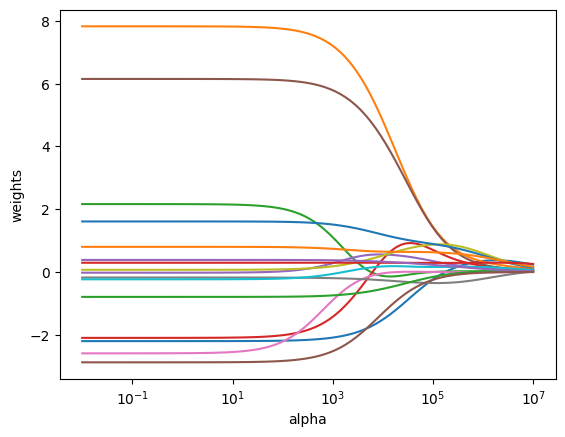

In [41]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

We can use the RidgeCV function to determine an optimal value for $\lambda$ based on leave-one-out cross-validation (LOOCV):

In [42]:
ridgecv = RidgeCV(alphas = lambdas)
ridgecv.fit(X, y)
ridgecv.alpha_

11679.270855560682

Building a ridge regression model with this optimal $\lambda$, we get:

In [43]:
ridge2 = Ridge(alpha = ridgecv.alpha_)
ridge2.fit(X, y)
print(pd.Series(ridge2.coef_, index = X.columns))
mean_squared_error(y, ridge2.predict(X))

AtBat     -1.443360
Hits       4.571630
HmRun     -0.140006
Runs       0.523664
RBI        0.553955
Walks      4.064171
Years     -0.028306
CAtBat    -0.271155
CHits      0.555396
CHmRun     0.181851
CRuns      1.164392
CRBI       0.645214
CWalks    -0.513905
PutOuts    0.293705
Assists    0.322846
Errors    -1.206413
dtype: float64


96812.61013827637

For $3$-fold cross-validation we get:

In [44]:
ridgecv = RidgeCV(alphas = lambdas, cv=3)
ridgecv.fit(X, y)
ridgecv.alpha_

9253.203955702538

In [45]:
ridge3 = Ridge(alpha = ridgecv.alpha_)
ridge3.fit(X, y)
print(pd.Series(ridge3.coef_, index = X.columns))
mean_squared_error(y, ridge3.predict(X))

AtBat     -1.551898
Hits       4.940360
HmRun     -0.117700
Runs       0.344884
RBI        0.558745
Walks      4.324953
Years     -0.051075
CAtBat    -0.260520
CHits      0.508350
CHmRun     0.173880
CRuns      1.203832
CRBI       0.649061
CWalks    -0.548922
PutOuts    0.294127
Assists    0.330310
Errors    -1.359501
dtype: float64


96561.53447785083

For the next part of this homework assignment, you'll investigate the same modeling question using lasso regression and the LassoCV function. Check out the optimal $\lambda$ values you get for lasso regression with LOOCV and 3-fold CV, and note which coefficients are set to $0$ is each case.

Specifically, you should:

1. Plot how the weights change for lasso regression as $\lambda$ gets large.
2. Calculate the optimal value of $\lambda$, and the corresponding model coefficients, using LOOCV.
3. Calculate the optimal value of $\lambda$, and the corresponding model coefficients, using 3-fold CV.

*Note*: Remember, for lasso, you'll probably need to set that max_iter parameter. A value like 100,000 should be good.

Optimal lambda (LOOCV): 110.90313431155938
Coefficients (LOOCV):
 AtBat     -1.682536
Hits       5.750015
HmRun      0.000000
Runs      -0.000000
RBI        0.000000
Walks      4.671893
Years     -0.000000
CAtBat    -0.229756
CHits      0.350818
CHmRun     0.000000
CRuns      1.272066
CRBI       0.743077
CWalks    -0.583380
PutOuts    0.289941
Assists    0.261729
Errors    -0.000000
dtype: float64

Optimal lambda (3-fold CV): 139.9804598013952
Coefficients (3-fold CV):
 AtBat     -1.550716
Hits       5.411148
HmRun      0.000000
Runs       0.000000
RBI        0.000000
Walks      4.417388
Years     -0.000000
CAtBat    -0.238500
CHits      0.388885
CHmRun     0.000000
CRuns      1.236410
CRBI       0.736682
CWalks    -0.543039
PutOuts    0.288647
Assists    0.251858
Errors    -0.000000
dtype: float64


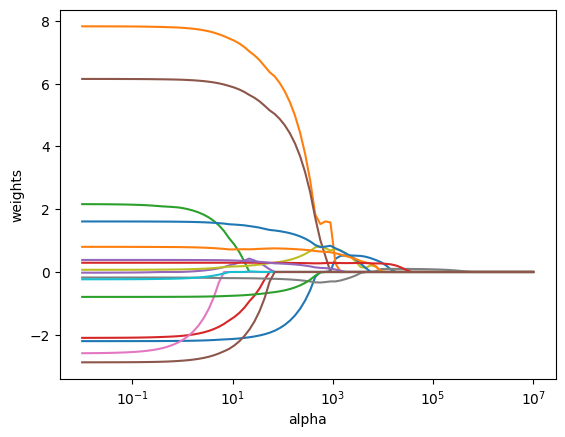

In [46]:
#TODO: Plot how the weights change for lasso regression as lambda gets large here.
# 1. Plot how the weights change for lasso regression as lambda gets large.
lasso = Lasso(max_iter=100000)
coefs = []

for l in lambdas:
    lasso.set_params(alpha=l)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

# 2. Calculate the optimal value of lambda, and the corresponding model coefficients, using LOOCV.
lassocv = LassoCV(alphas=lambdas, cv=None, max_iter=100000)  # LOOCV (cv=None)
lassocv.fit(X, y)
print("Optimal lambda (LOOCV):", lassocv.alpha_)
print("Coefficients (LOOCV):\n", pd.Series(lassocv.coef_, index=X.columns))

# 3. Calculate the optimal value of lambda, and the corresponding model coefficients, using 3-fold CV.
lassocv = LassoCV(alphas=lambdas, cv=3, max_iter=100000)  # 3-fold CV
lassocv.fit(X, y)
print("\nOptimal lambda (3-fold CV):", lassocv.alpha_)
print("Coefficients (3-fold CV):\n", pd.Series(lassocv.coef_, index=X.columns))


In [47]:
#TODO: Calculate the optimal value of lambda, and the corresponding model coefficients, using LOOCV.
# Assuming 'X' and 'y' are your predictor and response variables, and 'lambdas' is defined
lassocv = LassoCV(alphas=lambdas, cv=None, max_iter=100000)  # LOOCV (cv=None)
lassocv.fit(X, y)

print("Optimal lambda (LOOCV):", lassocv.alpha_)
print("Coefficients (LOOCV):\n", pd.Series(lassocv.coef_, index=X.columns))

Optimal lambda (LOOCV): 110.90313431155938
Coefficients (LOOCV):
 AtBat     -1.682536
Hits       5.750015
HmRun      0.000000
Runs      -0.000000
RBI        0.000000
Walks      4.671893
Years     -0.000000
CAtBat    -0.229756
CHits      0.350818
CHmRun     0.000000
CRuns      1.272066
CRBI       0.743077
CWalks    -0.583380
PutOuts    0.289941
Assists    0.261729
Errors    -0.000000
dtype: float64


In [48]:
#TODO: Calculate the optimal value of lambda, and the corresponding model coefficients, using 3-fold CV.
# Assuming 'X' and 'y' are your predictor and response variables, and 'lambdas' is defined
lassocv = LassoCV(alphas=lambdas, cv=3, max_iter=100000)  # 3-fold CV
lassocv.fit(X, y)

print("Optimal lambda (3-fold CV):", lassocv.alpha_)
print("Coefficients (3-fold CV):\n", pd.Series(lassocv.coef_, index=X.columns))

Optimal lambda (3-fold CV): 139.9804598013952
Coefficients (3-fold CV):
 AtBat     -1.550716
Hits       5.411148
HmRun      0.000000
Runs       0.000000
RBI        0.000000
Walks      4.417388
Years     -0.000000
CAtBat    -0.238500
CHits      0.388885
CHmRun     0.000000
CRuns      1.236410
CRBI       0.736682
CWalks    -0.543039
PutOuts    0.288647
Assists    0.251858
Errors    -0.000000
dtype: float64


How do the predictors with non-zero coefficients compare with the ones found earlier in the assignment using backward stepwise selection?